# Complete processing of SD2 cells. 

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mscl_utils as mscl
import os
import glob
import pandas as pd
import skimage.io

colors = mscl.set_plotting_style()
%matplotlib inline

In [107]:
imp.reload(mscl)

<module 'mscl_utils' from '/Users/gchure/Lab/PhillipsLab201401-XXX/lab_code/mscl_analysis/mscl_utils.py'>

Now that I have a scheme for segmenting, measuring, scraping informatin from images, I should now try to figure out a scheme for running it over one whole data set at time. As usual, I will run through my favorite data set, `SD2_5ulmin`.
  

First, I will need to rename all of the position and marker files as they are going to be out of order. This is because the positions have variable length, rather than 
having a run of 0's.

In [123]:
# Rename the markers list. 
markers = glob.glob('data/image_sets/SD2_5ulmin_post_3/*_xml.xml')
for i, m in enumerate(markers):
    _split = m.split('_')
    print(_split)

['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos0', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos10', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos11', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos12', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos13', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos14', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos15', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos16', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos17', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos18', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos19', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos1', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos2', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos3', 'xml.xml']
['data/image', 'sets/SD2', '5ulmin', 'post', '3/Pos4', 'xml.xml']


In [108]:
# Define the pre and post data sets. 
pre_phase = glob.glob('data/image_sets/SD2_5ulmin_pre_5/Pos*/*Brightfield*.tif')
pre_fluo = glob.glob('data/image_sets/SD2_5ulmin_pre_5/Pos*/*GFP*.tif')
markers = glob.glob('data/image_sets/SD2_5ulmin_post_3/Pos*_xml.xml')
metadata = glob.glob('data/image_sets/SD2_5ulmin_pre_5/Pos*/metadata.txt')

The general scheme should be as follows;

1. Load images
2. Segment via contouring.
3. Save representative segmentation mask.
4. Load markers.
5. Link markers to objects.
6. Scrape Metadata
7. Include metadata info in csv. 
8. Save csv file. 


In [124]:
# Loop through each image. 
dfs = []
for i, _ in enumerate(pre_phase): 
    print('Processing image {0} of {1}.'.format(i+1, len(pre_phase)))
    # Parse the position name. 
    pos_name = pre_phase[i].split('/')[3]
    
    # Grab the correct marker file. 
    markers = glob.glob('data/image_sets/SD2_5ulmin_post_3/{0}_xml.xml'.format(pos_name))[0]
    
    # Load the images and segment. 
    phase_im = skimage.io.imread(pre_phase[i])
    fluo_im = skimage.io.imread(pre_fluo[i])
    seg = mscl.threshold_seg(phase_im, area_bounds=(1, 30))
    if np.max(seg) < 1:
        pass
    # Save the segmented image. 
    _ = mscl.save_seg('data/full_set_output/{0}_example_segmentation.pdf'.format(pos_name),
                     phase_im, seg)

    # Load the markers and instantiate the DataFrame. 
    positions = mscl.marker_parse(markers)
    df = mscl.link_markers(positions, seg, fluo_im)
    _ = mscl.show_connections('data/full_set_output/{0}_connections.pdf'.format(pos_name),
                             phase_im, df)
    plt.close('all')
    # Parse the metadata. 
    exp = mscl.scrape_metadata(metadata[i])
    cols = np.shape(df)[1] 
    keys = exp.keys()
    for j, k in enumerate(keys):
        df.insert(cols, k, exp[k])
    dfs.append(df)
    
# Merge all data frames together. 
data = pd.concat(dfs, axis=0, ignore_index=True)

# Include the strain information. 
data.insert(0, 'rbs', 'SD2')
data.to_csv('data/full_set_output/sd2_processed.csv')

Processing image 1 of 20.
Processing image 2 of 20.
Processing image 3 of 20.
Processing image 4 of 20.
Processing image 5 of 20.
Processing image 6 of 20.
Processing image 7 of 20.
Processing image 8 of 20.
Processing image 9 of 20.
Processing image 10 of 20.
Processing image 11 of 20.
Processing image 12 of 20.
Processing image 13 of 20.
Processing image 14 of 20.
Processing image 15 of 20.
Processing image 16 of 20.
Processing image 17 of 20.
Processing image 18 of 20.
Processing image 19 of 20.
Processing image 20 of 20.


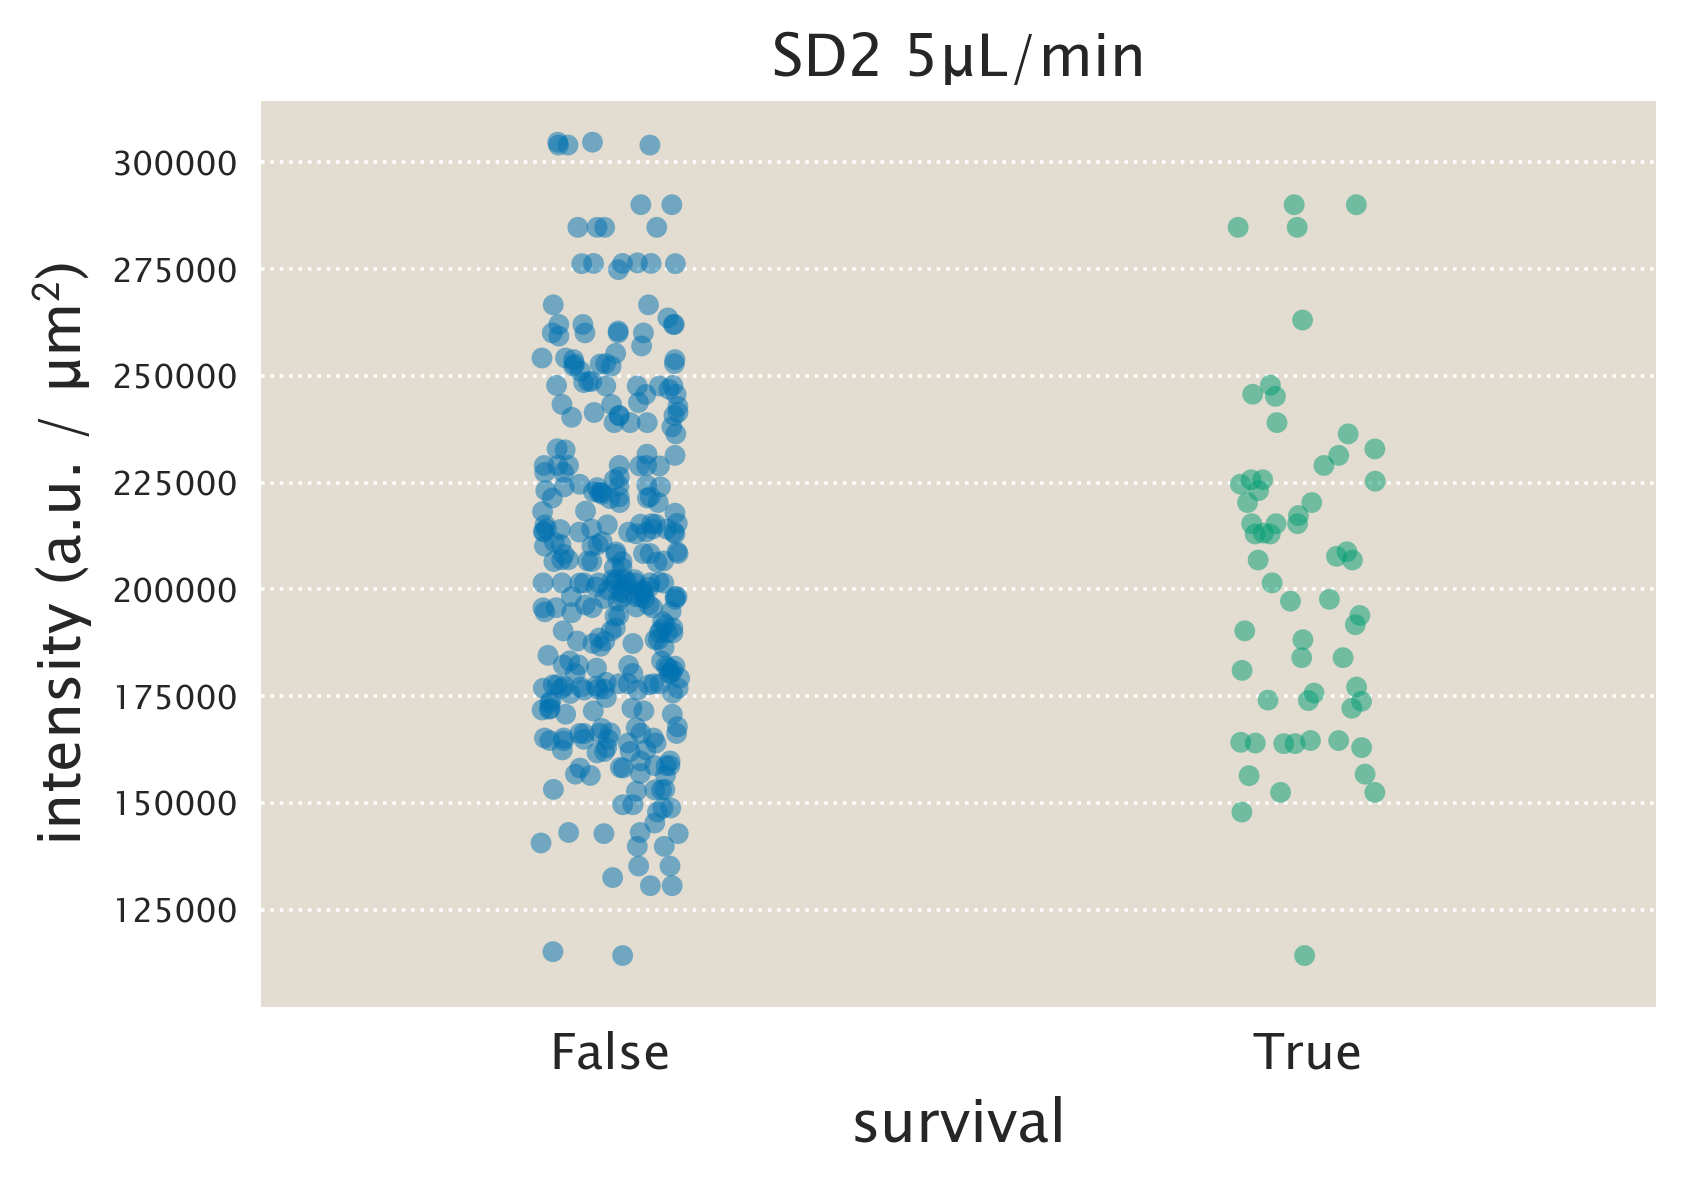

In [126]:
sns.stripplot(x='survival', y='intensity', data=data, jitter=True, alpha=0.5)
plt.xlabel('survival', fontsize=14)
plt.ylabel('intensity (a.u. / μm$^2$)', fontsize=14)
plt.title('SD2 5μL/min', fontsize=14)
plt.savefig('data/full_set_output/SD2_survival.pdf', bbox_inches='tight')

This seems to work relatively well, although there are still some segmentation errors that need to be corrected. In reality, simple thresholding may be sufficient. Now let me try another set. 

In [65]:
# Define the set data.
pre_phase = glob.glob('data/image_sets/SD4_5ulmin_pre_2/*Pos*.ome.tif')
markers = glob.glob('data/image_sets/SD4_5ulmin_post_1//
metadata = glob.glob('data/image_sets/SD4_5ulmin_pre_2/Pos*/metadata.txt')

#                 
dfs = []
for i, _ in enumerate(pre_phase): 
    print('Processing image {0} of {1}.'.format(i+1, len(pre_phase)))
    # Parse the position name. 
    pos_name = pre_phase[i].split('/')[3]
    
    # Load the images and segment. 
    phase_im = skimage.io.imread(pre_phase[i])
    fluo_im = skimage.io.imread(pre_fluo[i])
    seg = mscl.contour_seg(phase_im, 0.2, perim_bounds=(5, 50))
    if np.max(seg) <= 1:
        pass
    # Save the segmented image. 
    _ = mscl.save_seg('data/full_set_output/{0}_example_segmentation.pdf'.format(pos_name),
                     phase_im, seg)
    
    # Load the markers and instantiate the DataFrame. 
    positions = mscl.marker_parse(markers[i])
    df = mscl.link_markers(positions, seg, fluo_im)

    # Parse the metadata. 
    exp = mscl.scrape_metadata(metadata[i])
    cols = np.shape(df)[1] 
    keys = exp.keys()
    for j, k in enumerate(keys):
        df.insert(cols, k, exp[k])
    dfs.append(df)
    
# Merge all data frames together. 
data = pd.concat(dfs, axis=0, ignore_index=True)

# Include the strain information. 
data.insert(0, 'rbs', 'SD2')
data.to_csv('data/full_set_output/sd2_processed.csv')

In [67]:
im = skimage.io.imread(pre_phase[0])

In [73]:
pre_phase[i]

'data/image_sets/SD4_5ulmin_pre_2/SD4_5ulmin_pre_2_MMStack_Pos9.ome.tif'

In [78]:
pre_phase[i].split('_')[-1].rstrip('.ome.tif')

'Pos9'

In [88]:
data

,rbs,survival,x_pos,y_pos,mask_label,label_cent_x,label_cent_y,intensity,area,date,GFP_exp_ms,Brightfield_exp_ms
0,SD2,False,303,445,18.0,297.396887,450.603113,209192.910992,6.5792,20170329,50,10
1,SD2,False,274,442,17.0,276.080292,446.357664,222422.160128,3.5072,20170329,50,10
2,SD2,False,237,454,20.0,247.472222,455.590278,245365.939670,3.6864,20170329,50,10
3,SD2,False,177,457,19.0,191.765690,457.916318,223924.555439,6.1184,20170329,50,10
4,SD2,False,203,456,19.0,191.765690,457.916318,223924.555439,6.1184,20170329,50,10
5,SD2,False,281,458,17.0,276.080292,446.357664,222422.160128,3.5072,20170329,50,10
6,SD2,False,255,415,16.0,263.422535,414.309859,218312.885123,3.6352,20170329,50,10
7,SD2,False,292,401,15.0,290.073529,398.301471,251938.763787,3.4816,20170329,50,10
8,SD2,False,345,313,11.0,352.956522,313.775362,255816.066576,3.5328,20170329,50,10
9,SD2,False,257,332,14.0,233.000000,355.000000,128599.330357,0.1792,20170329,50,10
